In [1]:
"""
This script performs multi-band SENSE reconstruction
for single-shot EPI acquisition.

Authors:
    Zhengguo Tan <zhengguo.tan@gmail.com>
"""

'\nThis script performs multi-band SENSE reconstruction\nfor single-shot EPI acquisition.\n\nAuthors:\n    Zhengguo Tan <zhengguo.tan@gmail.com>\n'

In [1]:
import h5py
import os
import torch

import numpy as np
import sigpy as sp

from sigpy.mri import app, sms
from pathlib import Path

In [4]:
def MbSenseRecon(kdat, coil, sms_phase,
                 regu=0.001, max_iter=30,
                 device=sp.cpu_device):

    xp = device.xp

    output_devie = sp.get_device(kdat)

    kdat_device = sp.to_device(kdat, device=device)
    coil_device = sp.to_device(coil, device=device)
    sms_phase_device = sp.to_device(sms_phase, device=device)

    with device:

        N_coil, N_z, N_y, N_x = coil_device.shape

        img_shape = [1, N_z, N_y, N_x]

        # 1. coils
        S = sp.linop.Multiply(img_shape, coil_device)
        # 2. FFT
        F = sp.linop.FFT(S.oshape, axes=[-2, -1])
        # 4. SMS
        PHI = sp.linop.Multiply(F.oshape, sms_phase_device)
        SUM = sp.linop.Sum(PHI.oshape, axes=(-3,), keepdims=True)
        M = SUM * PHI
        # 5. sampling mask
        weights = app._estimate_weights(kdat_device, None, None, coil_dim=-4)
        W = sp.linop.Multiply(M.oshape, weights**0.5)

        # chain
        A = W * M * F * S

        print('  MR Forward Operator Input Shape: ', A.ishape)
        print('  MR Forward Operator Output Shape: ', A.oshape)

        # # Linear Least Square Solve
        AHA = lambda x: A.N(x) + regu * x
        AHy = A.H(kdat_device)

        img = xp.zeros(A.ishape, dtype=kdat_device.dtype)
        alg_method = sp.alg.ConjugateGradient(AHA, AHy, img,
                                max_iter=max_iter, verbose=True)

        while (not alg_method.done()):
            alg_method.update()

        return sp.to_device(img, device=output_devie)

In [5]:
def _assert_shape(shape1, shape2):

    assert len(shape1) == len(shape2)

    for i in range(len(shape1)):
        assert shape1[i] == shape2[i]

## Run the multi-band SENSE recon on a single-shot EPI data

In [6]:
# directory

DIR = os.path.dirname(os.path.abspath('MbSenseRecon.ipynb'))
print('> data directory: ', DIR)


> data directory:  D:\.WorkingSpace\CIP_Code\sigpy_copy


In [7]:
BASE_DIR = Path(DIR).parents[0]
print('> Base data directory: ', BASE_DIR)


> Base data directory:  D:\.WorkingSpace\CIP_Code


In [8]:
# device
device = sp.cpu_device
print('> run on device: ', device)

> run on device:  <CPU Device>


In [11]:
# k-space imaging echo
f = h5py.File('D:\.WorkingSpace\CIP_Code\sigpy_copy\data/1.7x1.7x4.0mm_kdat.h5', 'r')
f.keys()

<KeysViewHDF5 ['Accel_PE', 'MB', 'Segments', 'Slices', 'kdat']>

In [12]:
# Exploring all keys
kdat = f['kdat'][:]
MB = f['MB'][()]
N_Accel_PE = f['Accel_PE'][()]
segments = f['Segments'][()]
slices = f['Slices'][()]
f.close()

print('Kdat original shape: ', kdat.shape)
print('MB: ', MB)
print('Accel_PE: ', N_Accel_PE) # Acceleration factors in the phase-encoding direction
print('Segments: ', segments)
print('Slices: ', slices)


Kdat original shape:  (1, 1, 1, 1, 1, 1, 1, 12, 1, 1, 1, 1, 1, 130, 16, 130)
MB:  3
Accel_PE:  2
Segments:  1
Slices:  3


In [13]:
# Reformatting kdat
kdat = np.squeeze(kdat)  # 4 dim
kdat = np.swapaxes(kdat, -2, -3)

N_diff, N_coil, N_y, N_x = kdat.shape
print('> kdat shape: ', kdat.shape)
kdat = kdat[:, None, :, None, :, :]  # 6dim
# TODO: Ask why do I need 6 dimensions????

print('> kdat shape: ', kdat.shape)

> kdat shape:  (12, 16, 130, 130)
> kdat shape:  (12, 1, 16, 1, 130, 130)


In [15]:
# coil sensitivity maps
f = h5py.File('D:\.WorkingSpace\CIP_Code\sigpy_copy\data/1.7x1.7x4.0mm_refs.h5', 'r')
#f.keys()  # <KeysViewHDF5 ['refs']>
refs = f['refs'][:]
f.close()
print('> refs shape: ', refs.shape)

> refs shape:  (16, 3, 130, 130)


In [16]:
# Calculating each sensitivity map according to each slice
N_slices = refs.shape[1]
_assert_shape(kdat.shape[-2:], refs.shape[-2:])

mps = []
for s in range(N_slices):
    print('  ' + str(s).zfill(3))

    c = app.EspiritCalib(refs[:, s, :, :], thresh=0.03,
                        crop=0.95,
                        device=device, show_pbar=False).run()
    mps.append(sp.to_device(c))

mps = np.array(mps)
print(mps.shape)  # (3, 16, 130, 130)

mps = mps[[0, 2, 1], ...]  # slice reordering
print(mps.shape)  # (3, 16, 130, 130)

mps = np.swapaxes(mps, 0, 1)
print(mps.shape)   #(16, 3, 130, 130)


  000
  001
  002
(3, 16, 130, 130)
(3, 16, 130, 130)
(16, 3, 130, 130)


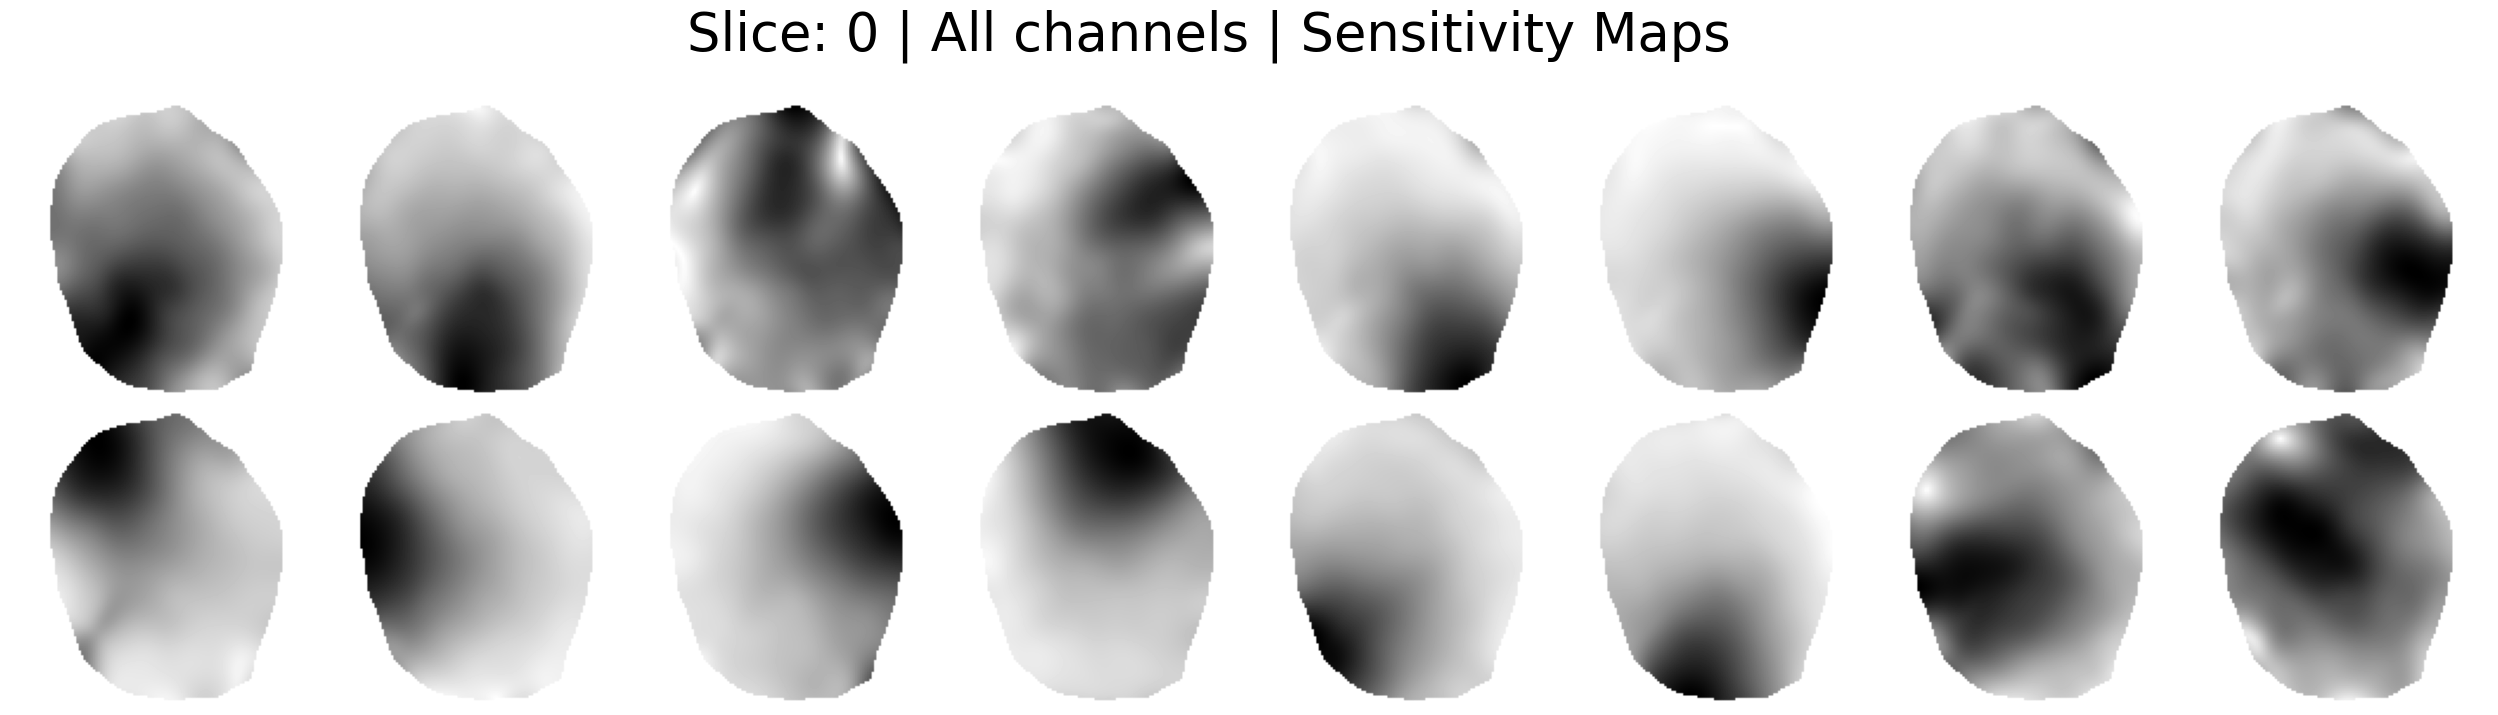

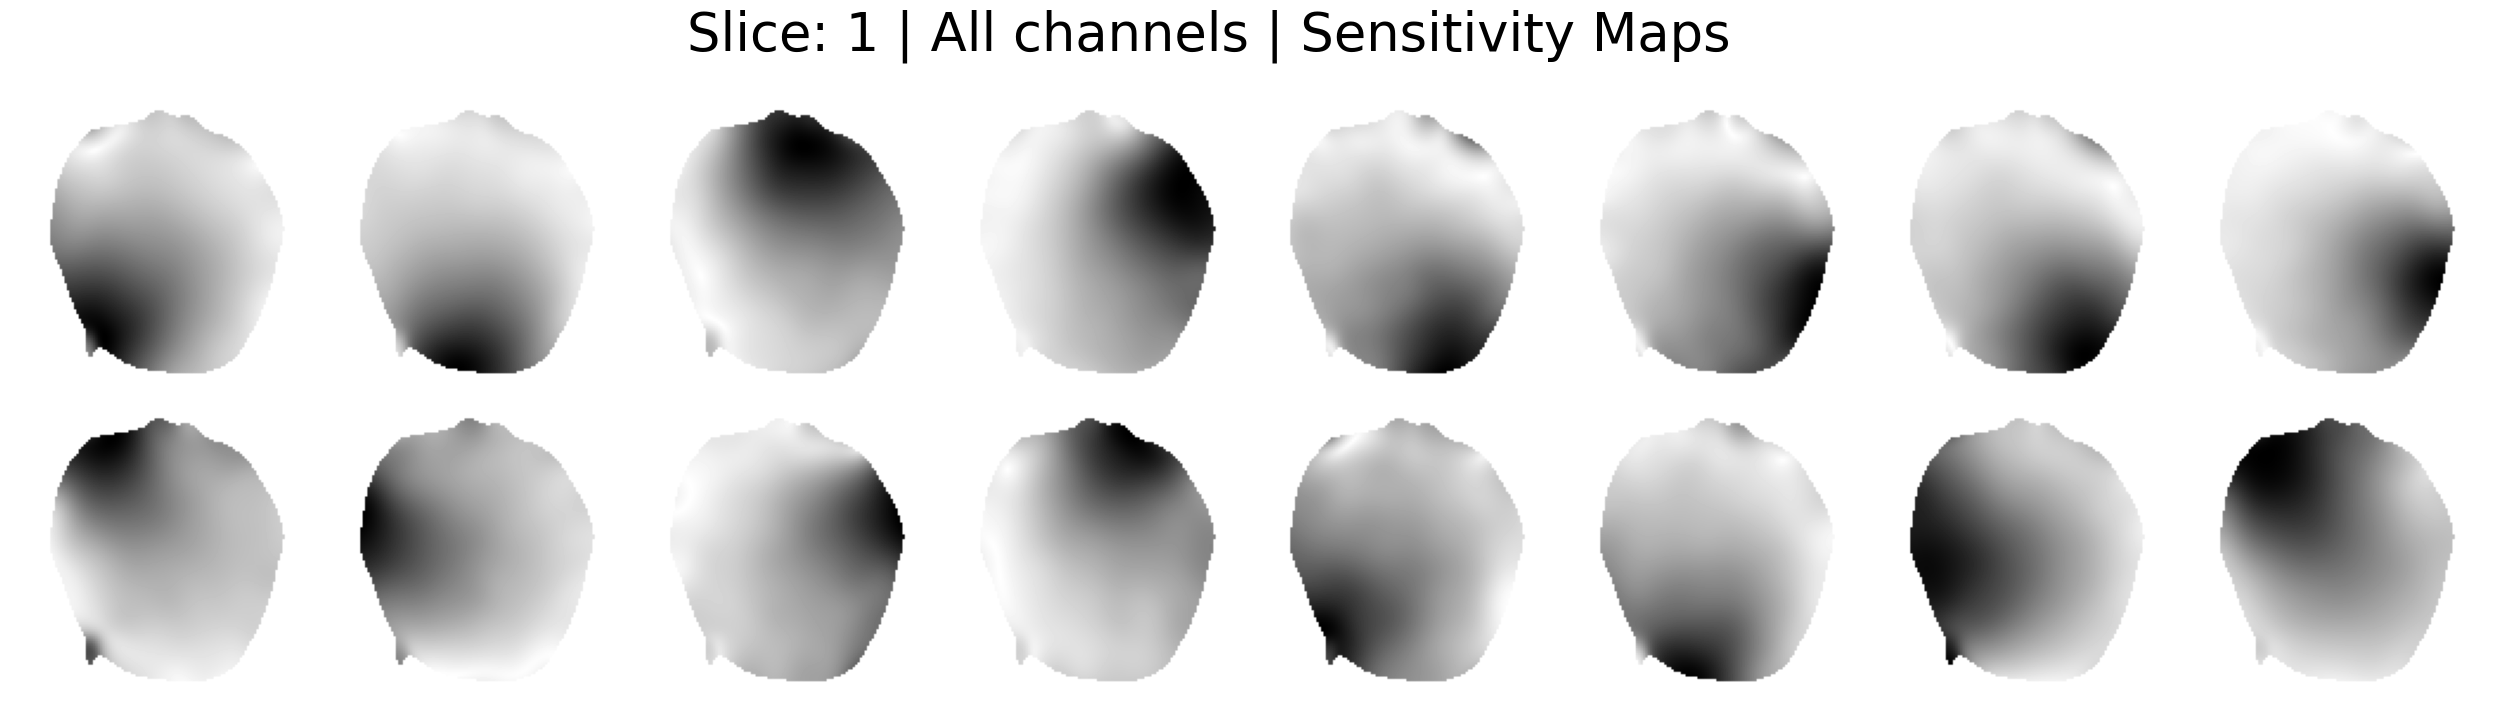

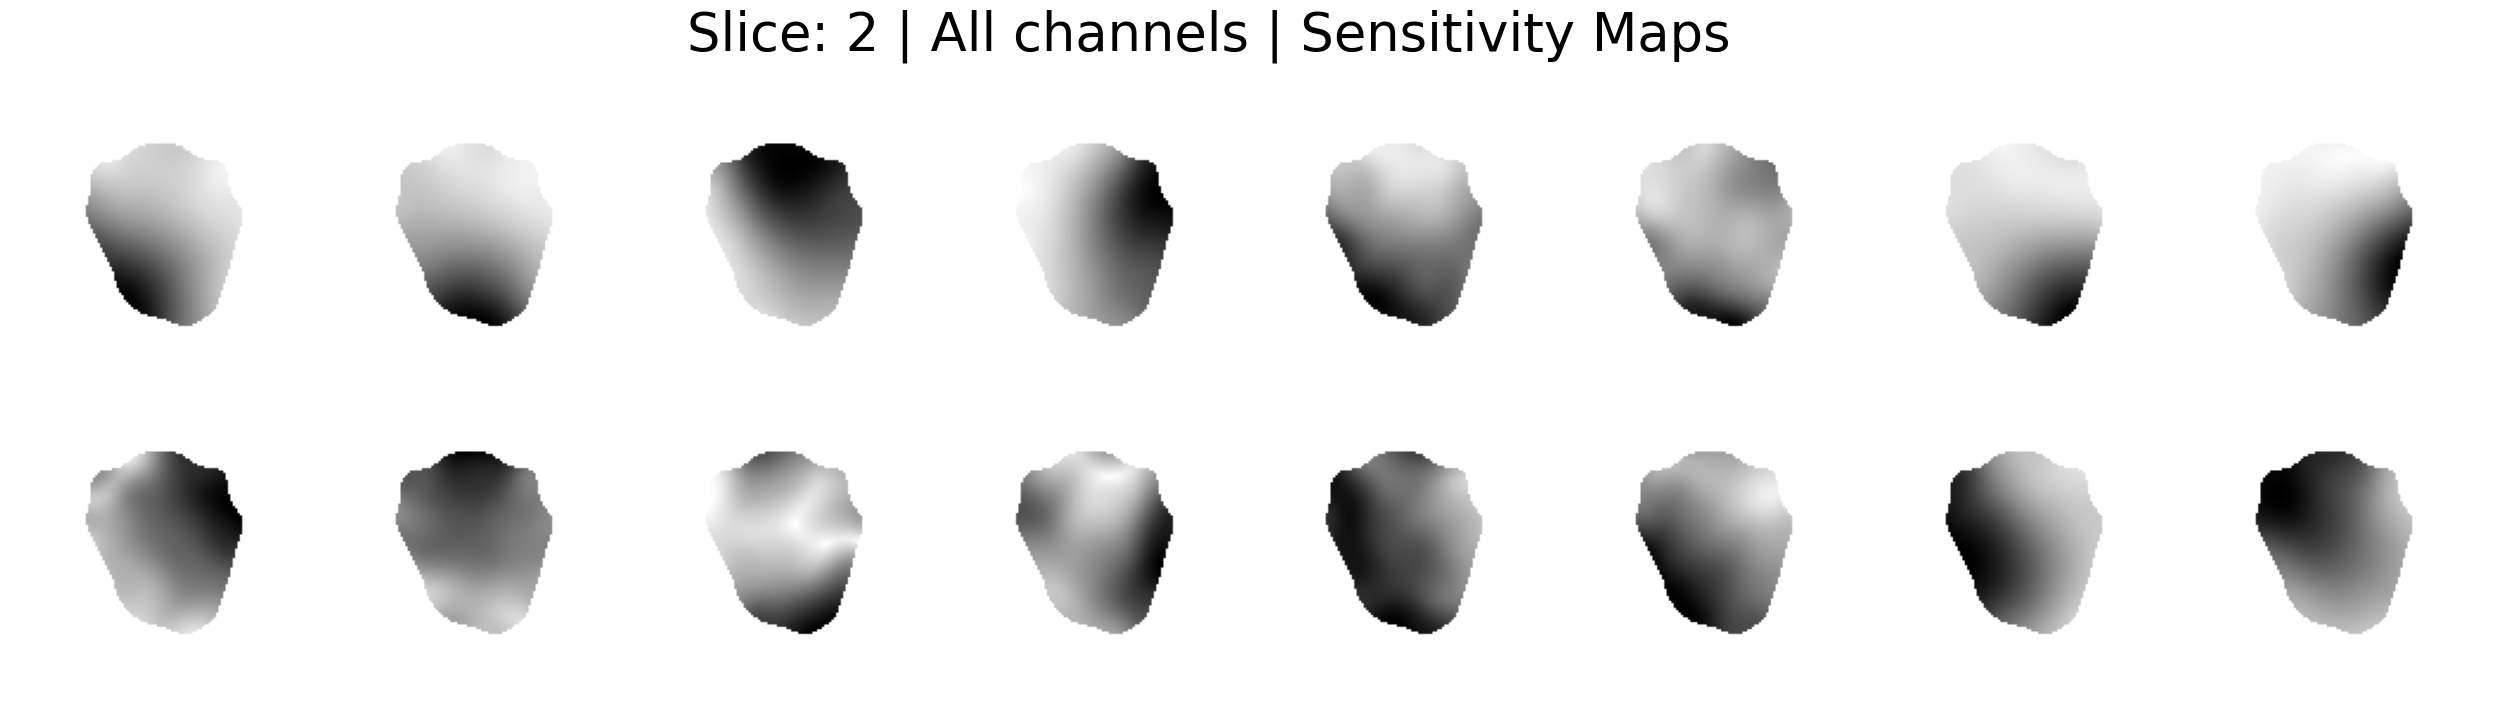

In [17]:
# Let's see the sensitivity maps
import matplotlib.pyplot as plt
# General parameters
plot_rows=2
plot_columns=8
channels_n= mps.shape[0]
domain = 'Sensitivity Maps'

# Contrast image 0
images = mps[:,0,:,:]
f, ax = plt.subplots(plot_rows, plot_columns, figsize=(32, 8))
number_channels = 1
for m in range(plot_rows):
    for n in range(plot_columns):
        # print(n + m*plot_columns)
        ax[m][n].set_axis_off()
        if number_channels <= channels_n:
            #print("breaking | P: ")
            ax[m][n].imshow(1-abs(images[n + m * plot_columns, ...]), cmap='gray')
            number_channels = number_channels + 1

title = 'Slice: 0 | All channels | {}'.format(domain)
f.suptitle(title,  fontsize = 38)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Contrast image 1
images = images = mps[:,1,:,:]
f, ax = plt.subplots(plot_rows, plot_columns, figsize=(32, 8))
number_channels = 1
for m in range(plot_rows):
    for n in range(plot_columns):
        # print(n + m*plot_columns)
        ax[m][n].set_axis_off()
        if number_channels <= channels_n:
            #print("breaking | P: ")
            ax[m][n].imshow(1-abs(images[n + m * plot_columns, ...]), cmap='gray')
            number_channels = number_channels + 1

title = 'Slice: 1 | All channels | {}'.format(domain)
f.suptitle(title, fontsize = 38)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Contrast image 2
images = images = mps[:,2,:,:]
f, ax = plt.subplots(plot_rows, plot_columns, figsize=(32, 8))
number_channels = 1
for m in range(plot_rows):
    for n in range(plot_columns):
        # print(n + m*plot_columns)
        ax[m][n].set_axis_off()
        if number_channels <= channels_n:
            #print("breaking | P: ")
            ax[m][n].imshow(1-abs(images[n + m * plot_columns, ...]), cmap='gray')
            number_channels = number_channels + 1

title = 'Slice: 2 | All channels | {}'.format(domain)
f.suptitle(title, fontsize=38)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [18]:
# Write sensitivity maps
f = h5py.File('D:\.WorkingSpace\CIP_Code\sigpy_copy\data/1.7x1.7x4.0mm_coil.h5', 'w')
f.create_dataset('C', data=mps)
f.close()

print('> mps shape: ', mps.shape)

> mps shape:  (16, 3, 130, 130)


In [33]:
# multi-band phase shift
yshift = []
for b in range(MB):
    yshift.append(b / N_Accel_PE)
print('yshift: ', yshift)

sms_phase = sms.get_sms_phase_shift([MB, N_y, N_x], MB=MB, yshift=yshift)
print('sms phase shape: ',sms_phase.shape)

yshift:  [0.0, 0.5, 1.0]
 > sms: yshift  [0.0, 0.5, 1.0]
sms phase shape:  (3, 130, 130)


In [39]:
# Reconstruction
R = []
for d in range(N_diff):
    img = MbSenseRecon(kdat[d], mps, sms_phase, device=device)
    R.append(img)

#f = h5py.File('D:\.WorkingSpace\CIP_Code\sigpy_copy\data/1.7x1.7x4.0mm_MbSense.h5', 'w')
#f.create_dataset('R', data=R)
#f.close()
R_np = np.array(R)
print(R_np.shape)

  MR Forward Operator Input Shape:  [1, 3, 130, 130]
  MR Forward Operator Output Shape:  [1, 16, 1, 130, 130]
  cg iter:  0; resid:      0.005684
  cg iter:  1; resid:      0.003303
  cg iter:  2; resid:      0.001769
  cg iter:  3; resid:      0.001066


KeyboardInterrupt: 

In [25]:
R_np = np.array(R)
print(R_np.shape)
R_np_s =np.squeeze(R_np)
print(R_np_s.shape)

(12, 1, 3, 130, 130)
(12, 3, 130, 130)


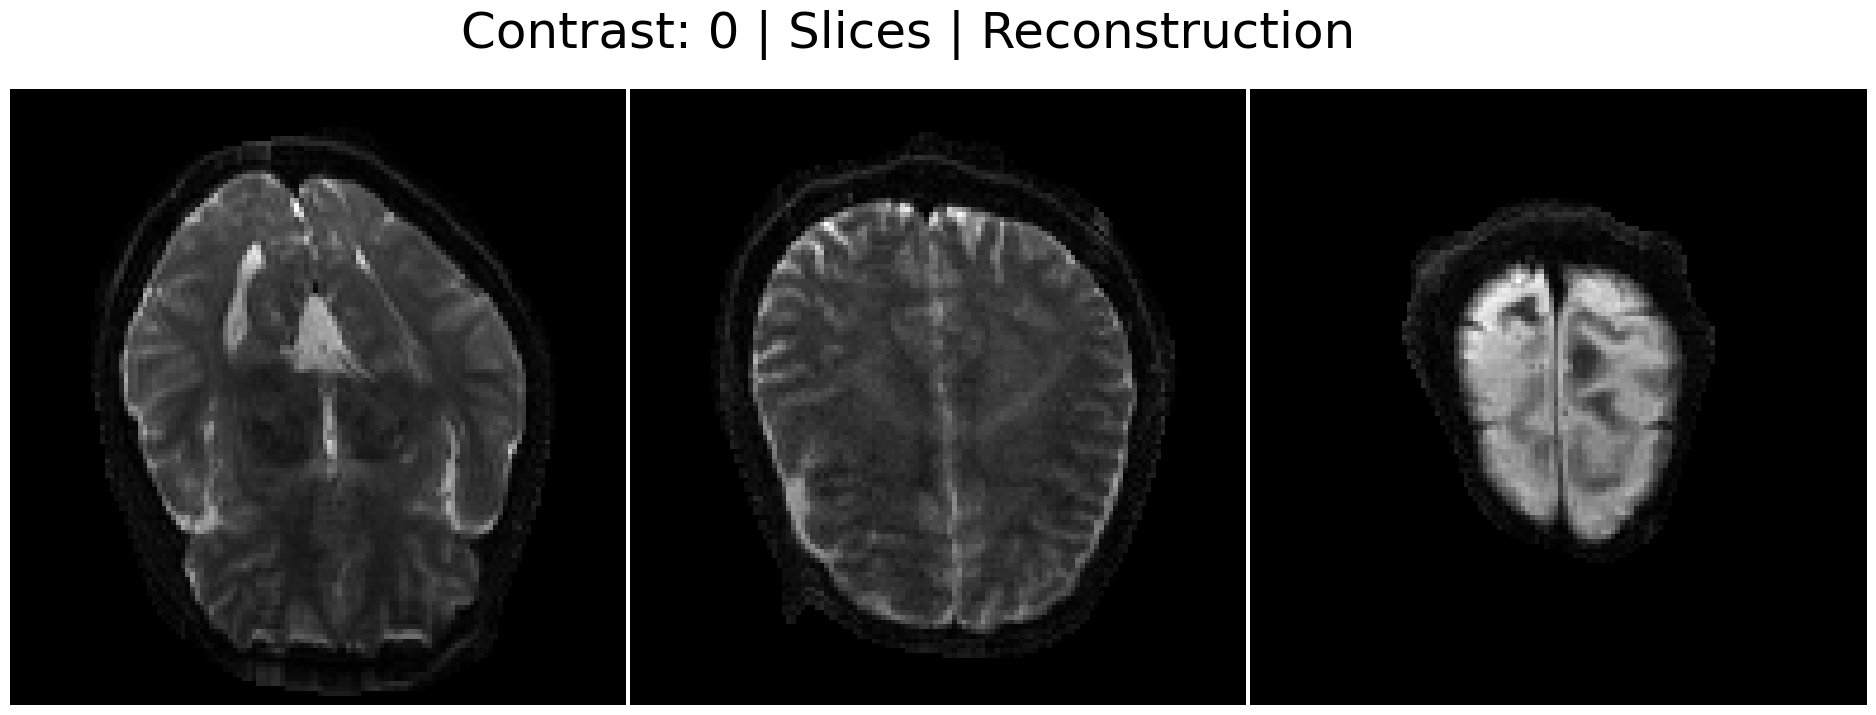

In [24]:
# Let's visualize the images:
fig, ax = plt.subplots(nrows=1,ncols=3, squeeze=False, figsize=(24, 8))

ax[0][0].imshow(abs(R_np_s[0,0,:,:]), cmap='gray')
ax[0][1].imshow(abs(R_np_s[0,1,:,:]), cmap='gray')
ax[0][2].imshow(abs(R_np_s[0,2,:,:]), cmap='gray')
ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[0][2].set_axis_off()

domain = 'Reconstruction'
title = 'Contrast: 0 | Slices | {}'.format(domain)
fig.suptitle(title, fontsize=36)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3, squeeze=False, figsize=(24, 8))

ax[0][0].imshow(abs(sms_phase[0,:,:]), cmap='gray')
ax[0][1].imshow(abs(sms_phase[1,:,:]), cmap='gray')
ax[0][2].imshow(abs(sms_phase[2,:,:]), cmap='gray')
ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[0][2].set_axis_off()

domain = 'sms_phase_device'
title = 'xxxx | Slices | {}'.format(domain)
fig.suptitle(title, fontsize=36)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()